In [1]:
import sys
sys.path.append("..")
from lib.kalman_gst import *  
from pygsti.modelpacks import smq1Q_XYI as std

In [2]:
SEED = 2021
SAMPLES = 256
np.random.seed(SEED)

In [3]:
def dirichlet_covar(count_vec):
    total_counts = sum(count_vec)
    hdims = len(count_vec)
    mean_frequency = ( count_vec + np.ones(hdims) )/( total_counts + hdims )
    return 1/(total_counts + hdims + 1) * categorical_covar(mean_frequency)


def null_chi2_test(model, dataset, circ_list):
    chi2_stat = 1
    for idx, circ in enumerate(circ_list):
        cvec = vector_from_outcomes(dataset[circ].counts())
        rmat = dirichlet_covar(cvec)
        
        
def observation_chi2_test(model, model_covar, circ, count_vec):
    total_counts = sum(count_vec)
    hdims = len(count_vec)
    mean_frequency = ( count_vec + np.ones(hdims) )/( total_counts + hdims )
    rmat = categorical_covar(mean_frequency) # estimate of sampling covar
    observation = count_vec/total_counts
    prediction = vector_from_outcomes(model.probabilities(circ), hdims)
    innov = observation - prediction 
    jac = matrix_from_jacob(model.sim.dprobs(circ), hdims)
    smat = rmat + jac@model_covar@jac.T
    return innov.T@np.linalg.pinv(smat)@innov
    

# Example 1

Performance of many exact extended filters vs batched MLE

In [4]:
# setup the datagen model
max_fogi_error_rate = 0.05
mdl_datagen = std.target_model('H+s')
basis1q = pygsti.baseobjs.Basis.cast('pp', 4)
gauge_basis = pygsti.baseobjs.CompleteElementaryErrorgenBasis(
                        basis1q, mdl_datagen.state_space, elementary_errorgen_types='HS')
mdl_datagen.setup_fogi(gauge_basis, None, None, reparameterize=True,
                     dependent_fogi_action='drop', include_spam=True)
ar = mdl_datagen.fogi_errorgen_components_array(include_fogv=False, normalized_elem_gens=True)
target_model = mdl_datagen.copy()
np.random.seed(SEED)
ar = max_fogi_error_rate * np.random.rand(len(ar))
mdl_datagen.set_fogi_errorgen_components_array(ar, include_fogv=False, normalized_elem_gens=True)

In [5]:
# make an edesign and simulate the data
maxLengths = [1,2,4,8,16]
maxlength_edesign = pygsti.protocols.StandardGSTDesign(target_model, std.prep_fiducials(), std.meas_fiducials(),
                                                std.germs(), maxLengths)
dataset = pygsti.data.simulate_data(mdl_datagen, maxlength_edesign, SAMPLES, seed=SEED) #, sample_error='none')

In [6]:
mle_estimates, edesigns = make_mle_estimates(dataset, std, target_model, maxLengths)

--- Iterative GST: [##################################################] 100.0%  92 circuits ---
Iterative GST Total Time: 0.7s
--- Iterative GST: [##################################################] 100.0%  168 circuits ---
Iterative GST Total Time: 0.8s
--- Iterative GST: [##################################################] 100.0%  285 circuits ---
Iterative GST Total Time: 1.4s
--- Iterative GST: [##################################################] 100.0%  448 circuits ---
Iterative GST Total Time: 2.2s
--- Iterative GST: [##################################################] 100.0%  616 circuits ---
Iterative GST Total Time: 3.3s


In [7]:
germ_length_ranges = {
    0: [0, 92], 
    1: [92, 168], 
    2: [168, 285], 
    3: [285, 448],
    4: [448, 616]
}

# many random models

In [8]:
def random_copy(max_error_rate, target_model):
    np.random.seed()
    output_model = target_model.copy()
    er = max_error_rate * np.random.rand(target_model.num_params)
    output_model.from_vector(er)
    return output_model

In [9]:
# setup the fogi model
target_model = std.target_model('H+s')
basis1q = pygsti.baseobjs.Basis.cast('pp', 4)
gauge_basis = pygsti.baseobjs.CompleteElementaryErrorgenBasis(
                        basis1q, target_model.state_space, elementary_errorgen_types='HS')
target_model.setup_fogi(gauge_basis, None, None, reparameterize=True,
                     dependent_fogi_action='drop', include_spam=True)

In [10]:
avg_fidel = 0
idx = 0
while idx < 500:
    noise_model = random_copy(0.09, target_model)
    if model_is_cptp(noise_model):
        avg_fidel += avg_gs_infidelity(noise_model, target_model)
        idx += 1
    else:
        print('non cptp model')
print(avg_fidel/500)

0.10261669627840239


In [56]:
# make many random FOGI models with same AGSI
target_avg_infidelity = 0.10
fidelity_epsilon = 0.005
num_noise_models = 5


noise_model_list = []
idx = 0
while idx < num_noise_models:
    noise_model = random_copy(0.09, target_model)
    if model_is_cptp(noise_model):
        infidel = avg_gs_infidelity(noise_model, target_model)
        if abs(infidel - target_avg_infidelity) < fidelity_epsilon:
            noise_model_list.append(noise_model)
            idx += 1
        else:
            print(f'outlying model of fidelity {infidel}')
    else:
        print('non cptp model')

outlying model of fidelity 0.11118806251584656
outlying model of fidelity 0.09398294616428671
outlying model of fidelity 0.10553858716247728
outlying model of fidelity 0.08049084540084295
outlying model of fidelity 0.08451674275553944
outlying model of fidelity 0.08809287289285361
outlying model of fidelity 0.1050674547544574
outlying model of fidelity 0.10891757846258936
outlying model of fidelity 0.109027859781416
outlying model of fidelity 0.12195515783338451
outlying model of fidelity 0.10516343457983497
outlying model of fidelity 0.06790974770486809
outlying model of fidelity 0.12441579295235687
outlying model of fidelity 0.11633311264183226
outlying model of fidelity 0.09378069408807022
outlying model of fidelity 0.09062061417537375
outlying model of fidelity 0.07582997102944004
outlying model of fidelity 0.07732383139876524
outlying model of fidelity 0.09376470564510142
outlying model of fidelity 0.07650627041616509
outlying model of fidelity 0.07455576266736023
outlying model o

In [57]:
num_samples = 256
maxLengths = [1,2,4,8]
prior_model = target_model
prior_covar = 0.01*np.eye(prior_model.num_params)

list_of_model_lists = []
list_of_covars_lists = []
datasets = []
mle_estimates_history = []

maxlength_edesign = std.create_gst_experiment_design(maxLengths[-1])
for model in noise_model_list:
    dataset = pygsti.data.simulate_data(model, maxlength_edesign, num_samples, seed=SEED)
    datasets.append(dataset)
    mle_estimates, edesigns = make_mle_estimates(dataset, std, target_model, maxLengths)
    mle_estimates_history.append(mle_estimates)
    circ_list = maxlength_edesign.circuit_lists[-1]
    post_model, post_covar, saved_data = filter_dataset(prior_model, prior_covar, dataset, circ_list, 
                   None, None, clip_range=[-1, 1],
                   max_itr=1, itr_eps=1e-4,
                   save_params_and_covars=True, save_prior_innovations=False, save_posterior_innovations=False, save_kgains=False)
    vector_history = saved_data[0]
    covar_history = saved_data[1]
    list_of_model_lists.append(vector_history)
    list_of_covars_lists.append(covar_history)

--- Iterative GST: [##################################################] 100.0%  92 circuits ---
Iterative GST Total Time: 0.7s
--- Iterative GST: [##################################################] 100.0%  168 circuits ---
Iterative GST Total Time: 0.9s
--- Iterative GST: [##################################################] 100.0%  285 circuits ---
Iterative GST Total Time: 1.6s
--- Iterative GST: [##################################################] 100.0%  448 circuits ---
Iterative GST Total Time: 2.1s


100%|██████████████████████████████████████████████████████████████████████████| 448/448 [00:32<00:00, 13.98it/s]


--- Iterative GST: [##################################################] 100.0%  92 circuits ---
Iterative GST Total Time: 1.0s
--- Iterative GST: [##################################################] 100.0%  168 circuits ---
Iterative GST Total Time: 1.2s
--- Iterative GST: [##################################################] 100.0%  285 circuits ---
Iterative GST Total Time: 1.9s
--- Iterative GST: [##################################################] 100.0%  448 circuits ---
Iterative GST Total Time: 2.6s


100%|██████████████████████████████████████████████████████████████████████████| 448/448 [00:44<00:00, 10.11it/s]


--- Iterative GST: [##################################################] 100.0%  92 circuits ---
Iterative GST Total Time: 0.9s
--- Iterative GST: [##################################################] 100.0%  168 circuits ---
Iterative GST Total Time: 1.1s
--- Iterative GST: [##################################################] 100.0%  285 circuits ---
Iterative GST Total Time: 2.0s
--- Iterative GST: [##################################################] 100.0%  448 circuits ---
Iterative GST Total Time: 2.6s


100%|██████████████████████████████████████████████████████████████████████████| 448/448 [00:35<00:00, 12.67it/s]

--- Iterative GST: [##################################################] 100.0%  92 circuits ---
Iterative GST Total Time: 0.9s
--- Iterative GST: [##################################################] 100.0%  168 circuits ---
Iterative GST Total Time: 1.1s
--- Iterative GST: [##################################################] 100.0%  285 circuits ---
Iterative GST Total Time: 1.9s
--- Iterative GST: [##################################################] 100.0%  448 circuits ---
Iterative GST Total Time: 2.6s


100%|██████████████████████████████████████████████████████████████████████████| 448/448 [00:34<00:00, 12.95it/s]


--- Iterative GST: [##################################################] 100.0%  92 circuits ---
Iterative GST Total Time: 0.9s
--- Iterative GST: [##################################################] 100.0%  168 circuits ---
Iterative GST Total Time: 1.1s
--- Iterative GST: [##################################################] 100.0%  285 circuits ---
Iterative GST Total Time: 2.0s
--- Iterative GST: [##################################################] 100.0%  448 circuits ---
Iterative GST Total Time: 2.7s


100%|██████████████████████████████████████████████████████████████████████████| 448/448 [00:34<00:00, 13.13it/s]


In [58]:
%matplotlib qt5

In [59]:
def make_singlerun_error_plot(plt_title, model_vectors, true_params, filter_covars, y_range, mle_estimate=None, germ_length_ranges=None, plt_spacing=25):
    """
    Make a plot of the evolution of the logarithm of error parameters and their uncertainty 
    
    --- Arguments ---
    plt_title: title of the plot
    model_vectors: list of model parameter vectors after each update
    true_params: parameters used in the datagen model
    filter_covars: list of model covariance matrices after each update
    y_range: display range for the y-axis
    mle_estimates: list of mle models after each increase in germ length
    germ_length_ranges: list of ranges of different germ lengths for the gst circuits
    plt_space: how frequently points are plotted 
    """
    fig, axs = plt.subplots(1, 2)
    
    fig.suptitle(plt_title)

    axs[0].set_title('Estimate')
    axs[1].set_title('Uncertainty')

    for i in range(0, len(model_vectors), plt_spacing):
        params = model_vectors[i]
        error = np.log10((params-true_params)@(params-true_params))
        axs[0].scatter(i, error, c='black')
        axs[1].scatter(i, np.log10((np.trace(filter_covars[i]))), c='black')
        
    if mle_estimates is not None:
        if germ_length_ranges is None:
            raise ValueError("no germ_length_ranges. Please set circuit ranges for the mle estimates")
        for i, mdl in enumerate(mle_estimates):
            mle_error = np.log10((mdl.to_vector()-true_params)@(mdl.to_vector()-true_params))
            mle_line, = axs[0].plot(germ_length_ranges[i], (mle_error, mle_error), c='red', label='MLE Estimate')
            
    axs[0].legend([mle_line, ], ['MLE Estimates',])
    if y_range is not None:
        axs[0].set_ylim(y_range[0], y_range[1])
        axs[1].set_ylim(y_range[0], y_range[1])
    axs[0].set_xlabel('Circuit Index')
    axs[1].set_xlabel('Circuit Index')
    axs[0].set_ylabel('MSE [log]')

In [63]:
i = 0
plt_spacing = 5
make_singlerun_error_plot('Evolution of Filter Estimate MSE', list_of_model_lists[i], noise_model_list[i].to_vector(), list_of_covars_lists[i], None, mle_estimates_history[i], germ_length_ranges, plt_spacing)

In [46]:
fiducial_model.from_vector(list_of_model_lists[5][-1])
avg_gs_infidelity(target_model, noise_model_list[5])

NameError: name 'fiducial_model' is not defined

In [17]:
assert len(mle_estimates) == len(list_of_model_lists) 
assert len(list_of_model_lists) == len(list_of_covars_lists)
assert len(list_of_covars_lists) == len(noise_model_list)

In [41]:
def make_average_performance_plot(

fig, axes = plt.subplots(nrows=1, ncols=1)
fiducial_model = target_model.copy()
plt_spacing = 5

axes.set_ylim(-4, 0)
#axes[1, 0].set_ylim(-4, 0)
#axes[1].set_ylim(-4, 0)
#axes[1, 1].set_ylim(-4, 0)

mle_mserrors = []
mle_agsis = []

mse_points = {idx: [] for idx in range(len(mle_estimates))}
agsi_points = {idx: [] for idx in range(len(mle_estimates))}

num_circs = len(list_of_model_lists[0])

for idx in range(len(mle_estimates)):
    mle_mserror = np.log10( mserror(mle_estimates[idx], noise_model_list[idx]) )
    mle_lines, = axes.plot((0, num_circs), (mle_mserror, mle_mserror), alpha=0.1, c='blue', lw=2)
    mle_mserrors.append(mle_mserror)
    #mle_agsi = np.log10( avg_gs_infidelity(mle_estimates[idx], noise_model_list[idx]) )
    #mle_agsis.append(mle_agsi)
    for id_model, model_vector in enumerate(list_of_model_lists[idx]):
        if id_model % plt_spacing == 0:
            fiducial_model.from_vector(model_vector)
            mse_points[idx].append(np.log10(mserror(fiducial_model, noise_model_list[idx])))
            #agsi_points[idx].append(np.log10(avg_gs_infidelity(fiducial_model, noise_model_list[idx])))

for idx in range(len(mse_points)):
    filter_lines, = axes.plot(range(0, num_circs, plt_spacing), mse_points[idx], alpha=0.7, c='black')
    #axes[1, 0].plot(agsi_points[idx], alpha=0.3, c='black')
#axes[1].hist(mle_mserrors, orientation="horizontal", color='black')
#axes[1, 1].hist(mle_agsis, orientation="horizontal")

axes.set_title('MSE between estimate and datagen')
axes.legend([filter_lines, mle_lines], ['Filter Estimate', 'Final MLE Estimate'])
#axes[1,0].set_title('AGSI between estimate and datagen')
#axes[1].set_title('MSE between MLE and datagen')
#axes[1,1].set_title('AGSI between MLE and datagen')

axes.set_ylabel('MSE [log]')
axes.set_xlabel('Circuit Index')

plt.show()

In [49]:
fig, axes = plt.subplots(nrows=2, ncols=1)

filter_mserrors = []
for id_model, vector_list in enumerate(list_of_model_lists):
    fiducial_model.from_vector(vector_list[-1])
    filter_mserrors.append( np.log10(mserror(fiducial_model, noise_model_list[id_model])) )

axes[0].hist(filter_mserrors, color='black')
axes[0].set_title('Final Filter Estimate MSE')
axes[1].hist(mle_mserrors, color='black')
axes[1].set_title('Finale MLE Estimate MSE')
axes[1].set_xlabel('MSE [log]')
axes[1].set_ylabel('Counts')
axes[0].set_ylabel('Counts')
axes[0].set_xlim([-3.8, -2.5])
axes[1].set_xlim([-3.8, -2.5])

(-3.8, -2.5)

In [100]:
num_samples = 1000
maxLengths = [1,2,4,8]
prior_model = target_model
prior_covar = 0.01*np.eye(prior_model.num_params)
proto = pygsti.protocols.GST(target_model, gaugeopt_suite=None, verbosity=1)

maxlength_edesign = pygsti.protocols.StandardGSTDesign(target_model, std.prep_fiducials(), std.meas_fiducials(),
                                                std.germs(), maxLengths)
    
list_of_model_lists = []
list_of_covars_lists = []
datasets = []
mset_titleates = []

for model in noise_model_list:
    dataset = pygsti.data.simulate_data(model, maxlength_edesign, num_samples, seed=None)
    datasets.append(dataset)
    data = pygsti.protocols.ProtocolData(maxlength_edesign, dataset)
    results_after = proto.run(data)
    mle_estimate = results_after.estimates['GateSetTomography'].models['final iteration estimate']
    mle_estimates.append(mle_estimate)
    circ_list = maxlength_edesign.circuit_lists[-1]
    post_model, post_covar, saved_data = filter_dataset(prior_model, prior_covar, dataset, circ_list, 
                   None, None, clip_range=[-1, 1],
                   max_itr=1, itr_eps=1e-4,
                   save_params_and_covars=True, save_prior_innovations=False, save_posterior_innovations=False, save_kgains=False)
    vector_history = saved_data[0]
    covar_history = saved_data[1]
    list_of_model_lists.append(vector_history)
    list_of_covars_lists.append(covar_history)

--- Iterative GST: [##################################################] 100.0%  448 circuits ---
Iterative GST Total Time: 1.4s


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 448/448 [00:24<00:00, 18.46it/s]

--- Iterative GST: [##################################################] 100.0%  448 circuits ---
Iterative GST Total Time: 1.5s


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 448/448 [00:24<00:00, 18.19it/s]


--- Iterative GST: [##################################################] 100.0%  448 circuits ---
Iterative GST Total Time: 1.5s


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 448/448 [00:23<00:00, 18.69it/s]


--- Iterative GST: [##################################################] 100.0%  448 circuits ---
Iterative GST Total Time: 1.5s


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 448/448 [00:25<00:00, 17.44it/s]

--- Iterative GST: [##################################################] 100.0%  448 circuits ---
Iterative GST Total Time: 1.5s


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 448/448 [00:24<00:00, 18.51it/s]

--- Iterative GST: [##################################################] 100.0%  448 circuits ---
Iterative GST Total Time: 1.5s


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 448/448 [00:23<00:00, 18.92it/s]

--- Iterative GST: [##################################################] 100.0%  448 circuits ---
Iterative GST Total Time: 2.0s


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 448/448 [00:24<00:00, 18.50it/s]

--- Iterative GST: [##################################################] 100.0%  448 circuits ---
Iterative GST Total Time: 1.5s


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 448/448 [00:24<00:00, 18.18it/s]

--- Iterative GST: [##################################################] 100.0%  448 circuits ---
Iterative GST Total Time: 1.5s


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 448/448 [00:24<00:00, 18.51it/s]

--- Iterative GST: [##################################################] 100.0%  448 circuits ---
Iterative GST Total Time: 1.5s


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 448/448 [00:24<00:00, 18.56it/s]

--- Iterative GST: [##################################################] 100.0%  448 circuits ---
Iterative GST Total Time: 1.5s


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 448/448 [00:25<00:00, 17.68it/s]


--- Iterative GST: [##################################################] 100.0%  448 circuits ---
Iterative GST Total Time: 1.5s


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 448/448 [00:25<00:00, 17.42it/s]


--- Iterative GST: [##################################################] 100.0%  448 circuits ---
Iterative GST Total Time: 1.5s


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 448/448 [00:24<00:00, 18.30it/s]

--- Iterative GST: [##################################################] 100.0%  448 circuits ---
Iterative GST Total Time: 1.5s


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 448/448 [00:24<00:00, 18.42it/s]

--- Iterative GST: [##################################################] 100.0%  448 circuits ---
Iterative GST Total Time: 1.5s


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 448/448 [00:24<00:00, 18.66it/s]


--- Iterative GST: [##################################################] 100.0%  448 circuits ---
Iterative GST Total Time: 1.4s


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 448/448 [00:24<00:00, 18.45it/s]

--- Iterative GST: [##################################################] 100.0%  448 circuits ---
Iterative GST Total Time: 2.0s


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 448/448 [00:24<00:00, 18.50it/s]

--- Iterative GST: [##################################################] 100.0%  448 circuits ---
Iterative GST Total Time: 1.4s


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 448/448 [00:23<00:00, 18.96it/s]

--- Iterative GST: [##################################################] 100.0%  448 circuits ---
Iterative GST Total Time: 1.4s


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 448/448 [00:24<00:00, 17.98it/s]

--- Iterative GST: [##################################################] 100.0%  448 circuits ---
Iterative GST Total Time: 1.5s


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 448/448 [00:24<00:00, 18.50it/s]


--- Iterative GST: [##################################################] 100.0%  448 circuits ---
Iterative GST Total Time: 1.6s


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 448/448 [00:24<00:00, 18.11it/s]

--- Iterative GST: [##################################################] 100.0%  448 circuits ---
Iterative GST Total Time: 1.5s


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 448/448 [00:25<00:00, 17.79it/s]

--- Iterative GST: [##################################################] 100.0%  448 circuits ---
Iterative GST Total Time: 1.5s


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 448/448 [00:24<00:00, 17.97it/s]

--- Iterative GST: [##################################################] 100.0%  448 circuits ---
Iterative GST Total Time: 1.6s


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 448/448 [00:24<00:00, 18.07it/s]

--- Iterative GST: [##################################################] 100.0%  448 circuits ---
Iterative GST Total Time: 1.5s


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 448/448 [00:25<00:00, 17.91it/s]

--- Iterative GST: [##################################################] 100.0%  448 circuits ---
Iterative GST Total Time: 1.5s


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 448/448 [00:23<00:00, 18.73it/s]


--- Iterative GST: [##################################################] 100.0%  448 circuits ---
Iterative GST Total Time: 2.2s


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 448/448 [00:25<00:00, 17.61it/s]

--- Iterative GST: [##################################################] 100.0%  448 circuits ---
Iterative GST Total Time: 1.6s


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 448/448 [00:24<00:00, 18.17it/s]

--- Iterative GST: [##################################################] 100.0%  448 circuits ---
Iterative GST Total Time: 1.4s


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 448/448 [00:24<00:00, 18.24it/s]

--- Iterative GST: [##################################################] 100.0%  448 circuits ---
Iterative GST Total Time: 1.6s


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 448/448 [00:25<00:00, 17.57it/s]


/tmp/ipykernel_12408/2231885081.py:22: RuntimeWarning: invalid value encountered in log10
  axes[1, 0].scatter(id_model, np.log10(avg_gs_infidelity(fiducial_model, noise_model_list[idx])), c='black', alpha=0.1)


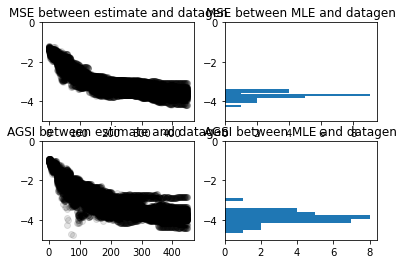

In [104]:
fig, axes = plt.subplots(nrows=2, ncols=2)
fiducial_model = target_model.copy()
plt_spacing = 1

axes[0, 0].set_ylim(-5, 0)
axes[1, 0].set_ylim(-5, 0)
axes[0, 1].set_ylim(-5, 0)
axes[1, 1].set_ylim(-5, 0)

mle_mserrors = []
mle_agsis = []

for idx in range(len(mle_estimates)):
    mle_mserror = np.log10( mserror(mle_estimates[idx], noise_model_list[idx]) )
    mle_mserrors.append(mle_mserror)
    mle_agsi = np.log10( avg_gs_infidelity(mle_estimates[idx], noise_model_list[idx]) )
    mle_agsis.append(mle_agsi)
    for id_model, model_vector in enumerate(list_of_model_lists[idx]):
        if id_model % plt_spacing == 0:
            fiducial_model.from_vector(model_vector)
            axes[0, 0].scatter(id_model, np.log10(mserror(fiducial_model, noise_model_list[idx])), c='black', alpha=0.1)
            axes[1, 0].scatter(id_model, np.log10(avg_gs_infidelity(fiducial_model, noise_model_list[idx])), c='black', alpha=0.1)
axes[0, 1].hist(mle_mserrors, orientation="horizontal")
axes[1, 1].hist(mle_agsis, orientation="horizontal")

axes[0,0].set_title('MSE between estimate and datagen')
axes[1,0].set_title('AGSI between estimate and datagen')
axes[0,1].set_title('MSE between MLE and datagen')
axes[1,1].set_title('AGSI between MLE and datagen')

plt.show()

### chi2 evolution

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 616/616 [03:20<00:00,  3.07it/s]


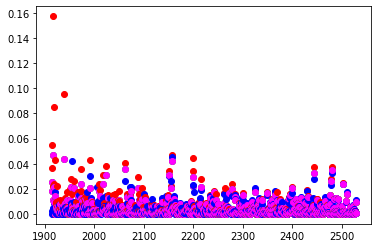

In [105]:
x0 = np.zeros(len(target_model.to_vector()))

covar_strength = 0.0001

ekf = setup_extended(target_model, x0_zero, covar_strength)

max_itr = 1
max_itr_epsilon = 1e-4

Q_add = 0*np.eye(len(target_model.to_vector()))
R_add = 0*np.eye(2)


# run over the largest set of GST circuits
for circ in tqdm(maxlength_edesign.circuit_lists[-1]):
    counts = dataset[circ].counts
    cvec = vector_from_outcomes(counts, 2**circ.width)
    freq = cvec/sum(cvec)

    prior_chi2 = observation_chi2_test(ekf.model, ekf.P, circ, cvec)

    _ = ekf.update(circ, cvec, [-1, 1], Q_add, R_add, max_itr, max_itr_epsilon)
    
    post_chi2 = observation_chi2_test(ekf.model, ekf.P, circ, cvec)
    
    true_chi2 = observation_chi2_test(mdl_datagen, np.zeros((mdl_datagen.num_params, mdl_datagen.num_params)), circ, cvec)
    
    reduced_prior_chi2 = observation_chi2_test(ekf.model, np.zeros((mdl_datagen.num_params, mdl_datagen.num_params)), circ, cvec)
    
    plt.scatter(idx, prior_chi2, c='red')
    plt.scatter(idx, post_chi2, c='green')
    plt.scatter(idx, true_chi2, c='blue')
    plt.scatter(idx, reduced_prior_chi2, c='magenta')
    
    idx += 1
num_circs = idx

# Example 2

Posterior Fit Performance compared with CPTP model

In [67]:
from scipy.stats import multinomial

def experimental_loglikelihood(circuit_list, dataset, model):
    """
    multinomial likelihood of observations under the given model 
    
    assumes all the circuits have the same number of qubits
    """
    hdims = 2**circuit_list[0].width
    count_matrix = np.zeros([0, hdims])
    pmat = np.zeros([0, hdims])
    for idx, circ in enumerate(circuit_list):
        count_vec = vector_from_outcomes(dataset[circ].counts, hdims)
        count_matrix = np.vstack([count_matrix, count_vec])
        p_model = vector_from_outcomes(model.probabilities(circ), hdims)
        pmat = np.vstack([pmat, p_model])
    return sum(multinomial.logpmf(count_matrix, sum(count_matrix[0, :]), pmat))

def max_loglikelihood(circuit_list, dataset):
    """
    max loglikelihood 
    """
    hdims = 2**circuit_list[0].width
    count_matrix = np.zeros([0, hdims])
    pmat = np.zeros([0, hdims])
    for idx, circ in enumerate(circuit_list):
        count_vec = vector_from_outcomes(dataset[circ].counts, hdims)
        count_matrix = np.vstack([count_matrix, count_vec])
        frequency = count_vec/sum(count_vec)
        pmat = np.vstack([pmat, frequency])
    return sum(multinomial.logpmf(count_matrix, sum(count_matrix[0, :]), pmat))

In [86]:
cptp_target = std.target_model('CPTP')

In [87]:
# setup the datagen model
max_fogi_error_rate = 0.12
mdl_datagen = std.target_model('H+s')
basis1q = pygsti.baseobjs.Basis.cast('pp', 4)
gauge_basis = pygsti.baseobjs.CompleteElementaryErrorgenBasis(
                        basis1q, mdl_datagen.state_space, elementary_errorgen_types='HS')
mdl_datagen.setup_fogi(gauge_basis, None, None, reparameterize=True,
                     dependent_fogi_action='drop', include_spam=True)
ar = mdl_datagen.fogi_errorgen_components_array(include_fogv=False, normalized_elem_gens=True)
fogi_target_model = mdl_datagen.copy()
np.random.seed(SEED)
ar = max_fogi_error_rate * np.random.rand(len(ar))
mdl_datagen.set_fogi_errorgen_components_array(ar, include_fogv=False, normalized_elem_gens=True)

In [88]:
avg_gs_infidelity(mdl_datagen, fogi_target_model)

0.11770128705202798

In [89]:
# make an edesign and simulate the data
maxLengths = [1,2,4]
maxlength_edesign = pygsti.protocols.StandardGSTDesign(cptp_target, std.prep_fiducials(), std.meas_fiducials(),
                                                std.germs(), maxLengths)
dataset = pygsti.data.simulate_data(mdl_datagen, maxlength_edesign, SAMPLES, seed=SEED) #, sample_error='none')

In [90]:
cptp_mle_estimates, edesigns = make_mle_estimates(dataset, std, cptp_target, maxLengths)

--- Iterative GST: [##################################################] 100.0%  92 circuits ---
Iterative GST Total Time: 3.1s
--- Iterative GST: [##################################################] 100.0%  168 circuits ---
Iterative GST Total Time: 6.3s
--- Iterative GST: [##################################################] 100.0%  285 circuits ---
Iterative GST Total Time: 7.8s


In [91]:
prior_cptp_covar = 0.1*np.eye(cptp_target.num_params)

In [93]:
post_cptp_mle1seed, cptp_mle1_covar, saved_data = filter_dataset(cptp_mle_estimates[0], prior_cptp_covar, dataset, maxlength_edesign.circuit_lists[-1], 
                   None, None, clip_range=[-1, 1],
                   max_itr=1, itr_eps=1e-4,
                   save_params_and_covars=True, save_prior_innovations=False, save_posterior_innovations=False, save_kgains=False)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 285/285 [00:22<00:00, 12.58it/s]


In [94]:
post_cptp_targetseed, cptp_targetseed_covar, saved_data = filter_dataset(cptp_target, prior_cptp_covar, dataset, maxlength_edesign.circuit_lists[-1], 
                   None, None, clip_range=[-1, 1],
                   max_itr=1, itr_eps=1e-4,
                   save_params_and_covars=True, save_prior_innovations=False, save_posterior_innovations=False, save_kgains=False)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 285/285 [00:25<00:00, 11.28it/s]


In [95]:
max_loglikelihood(maxlength_edesign.circuit_lists[-1], dataset)

-847.0902220850269

In [96]:
experimental_loglikelihood(maxlength_edesign.circuit_lists[-1], dataset, cptp_mle_estimates[0])

-999.9591684826103

In [97]:
experimental_loglikelihood(maxlength_edesign.circuit_lists[-1], dataset, cptp_mle_estimates[-1])

-971.311268200813

In [98]:
experimental_loglikelihood(maxlength_edesign.circuit_lists[-1], dataset, cptp_zero_ekf.model)

-2404.615271471128

In [99]:
experimental_loglikelihood(maxlength_edesign.circuit_lists[-1], dataset, cptp_mle1_ekf.model)

-971.329735215731

In [100]:
fogi_mle_estimates, edesigns = make_mle_estimates(dataset, std, fogi_target_model, maxLengths)

--- Iterative GST: [##################################################] 100.0%  92 circuits ---
Iterative GST Total Time: 0.7s
--- Iterative GST: [##################################################] 100.0%  168 circuits ---
Iterative GST Total Time: 0.8s
--- Iterative GST: [##################################################] 100.0%  285 circuits ---
Iterative GST Total Time: 1.2s


In [103]:
prior_fogi_covar = 0.1*np.eye(fogi_target_model.num_params)

In [111]:
post_fogi_mle1seed, mle1_covar, saved_data = filter_dataset(fogi_mle_estimates[0], prior_fogi_covar, dataset, maxlength_edesign.circuit_lists[-1], 
                   None, None, clip_range=[-1, 1],
                   max_itr=1, itr_eps=1e-4,
                   save_params_and_covars=True, save_prior_innovations=False, save_posterior_innovations=False, save_kgains=False)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 285/285 [00:13<00:00, 21.09it/s]


In [105]:
post_fogi_targetseed, targetseed_covar, saved_data = filter_dataset(fogi_target_model, prior_fogi_covar, dataset, maxlength_edesign.circuit_lists[-1], 
                   None, None, clip_range=[-1, 1],
                   max_itr=1, itr_eps=1e-4,
                   save_params_and_covars=True, save_prior_innovations=False, save_posterior_innovations=False, save_kgains=False)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 285/285 [00:13<00:00, 21.09it/s]


In [112]:
max_loglikelihood(maxlength_edesign.circuit_lists[-1], dataset)

-847.0902220850269

In [113]:
experimental_loglikelihood(maxlength_edesign.circuit_lists[-1], dataset, fogi_mle_estimates[0])

-994.3977133457206

In [114]:
experimental_loglikelihood(maxlength_edesign.circuit_lists[-1], dataset, fogi_mle_estimates[-1])

-976.8536459996624

In [115]:
experimental_loglikelihood(maxlength_edesign.circuit_lists[-1], dataset, post_fogi_mle1seed)

-977.3734515824826

In [117]:
experimental_loglikelihood(maxlength_edesign.circuit_lists[-1], dataset, post_fogi_targetseed)

-977.0866225452755

In [ ]:
log_likelihoods = [

In [86]:
def plot_covar_evals(covar_dict):
    evals = []
    for c in range(num_circs):
        circ_eval, _ = np.linalg.eig(covar_dict[c])
        evals.append(circ_eval)
    plt.matshow(abs(np.array(evals).T))
    
def plot_covar_svals(covar_dict):
    svals = []
    for c in range(num_circs):
        _, circ_sval, _ = np.linalg.svd(covar_dict[c])
        svals.append(circ_sval)
    plt.matshow(abs(np.array(svals).T))

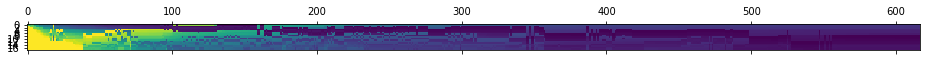

In [87]:
plot_covar_evals(mle1_covars)

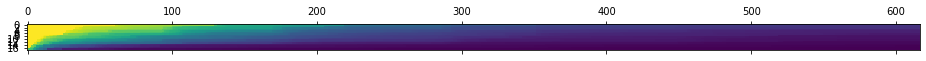

In [88]:
plot_covar_svals(mle1_covars)

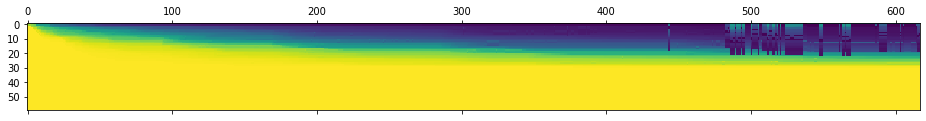

In [91]:
plot_covar_evals(cptp_mle1_covars)

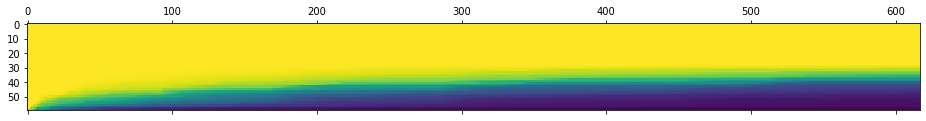

In [92]:
plot_covar_svals(cptp_mle1_covars)

In [ ]:
ar = mdl_datagen.fogi_errorgen_components_array(include_fogv=False, normalized_elem_gens=True)
datagen_models = []
estimates = []
data_sets = []
edesign_sets = []
for e in error_strengths:
    ar = e * np.random.rand(len(ar))
    mdl_datagen.set_fogi_errorgen_components_array(ar, include_fogv=False, normalized_elem_gens=True)
    datagen_models.append(mdl_datagen.copy())
    est, ds, edesigns = make_mle_estimates(mdl_datagen, target_model, [1, 2, 4, 8, 16], samples)
    estimates.append(est)
    data_sets.append(ds)
    edesign_sets.append(edesigns)

In [10]:
def random_hs_fogi_model(max_error_rate, hs_target_model):
    output_model = hs_target_model.copy()
    basis1q = pygsti.baseobjs.Basis.cast('pp', 4)
    gauge_basis = pygsti.baseobjs.CompleteElementaryErrorgenBasis(
                        basis1q, hs_target_model.state_space, elementary_errorgen_types='HS')
    output_model.setup_fogi(gauge_basis, None, None, reparameterize=True,
                     dependent_fogi_action='drop', include_spam=True)
    target_model = output_model.copy()
    ar = output_model.fogi_errorgen_components_array(include_fogv=False, normalized_elem_gens=True)
    np.random.seed()
    ar = max_error_rate * np.random.rand(len(ar))
    output_model.set_fogi_errorgen_components_array(ar, include_fogv=False, normalized_elem_gens=True)
    return output_model, target_model